In [1]:
# IMPORT SOME MODULES =========================================================================
%pylab inline

from astropy.io import fits
from matplotlib.mlab import griddata
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
from string import join
import os

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *
from tools.photometry import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# sizes ---------------------------------------------------------------------------------------
NR = 100
colors = "r", "b"
# output dir ----------------------------------------------------------------------------------
od = os.path.expandvars("$HOME/Documents/Publications/PhD-thesis/figures/")

In [3]:
ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
mask_ws = mask_ws&((ssag_tta["name"]=="SSAG000058")|(ssag_tta["name"]=="SSAG000104"))
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

sdss_tta = genfromtxt("../inputs/proof_chi-useless/outs/sdss/dynbas_output.log", dtype=None, names=True)
jpas_tta = genfromtxt("../inputs/proof_chi-useless/outs/jpas/dynbas_output.log", dtype=None, names=True)
spec_tta = genfromtxt("../inputs/proof_chi-useless/outs/spec/dynbas_output.log", dtype=None, names=True)

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

ocolor = loadtxt("data/sample-sim/ur_color.txt")
jpas_obs = zeros(ocolor.size, dtype=zip(fields, ["<f8"]*6))
spec_obs = copy(jpas_obs)
for m in fields:
    spec_obs[m] = loadtxt("data/sample-sim/SPEC_{}.txt".format(m))
    jpas_obs[m] = loadtxt("data/sample-sim/JPAS_{}.txt".format(m))

In [4]:
sfg_spec = spec_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_spec = spec_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_jpas = jpas_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_jpas = jpas_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_sdss = sdss_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_sdss = sdss_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_true = ssag_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]][0]
pag_true = ssag_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]][0]

k_spec = 5301-1-sfg_spec["gen"]
k_jpas = 56-1-sfg_jpas["gen"]
k_sdss = 5-1-sfg_sdss["gen"]

E_spec = 0.99962243
E_jpas = 0.96153846
E_sdss = 0.0

best_sfg_spec = argmin(abs(sfg_spec["chi_sq"]-E_spec))
best_sfg_jpas = argmin(abs(sfg_jpas["chi_sq"]-E_jpas))
best_sfg_sdss = argmin(abs(sfg_sdss["chi_sq"]-E_sdss))

best_pag_spec = argmin(abs(pag_spec["chi_sq"]-E_spec))
best_pag_jpas = argmin(abs(pag_jpas["chi_sq"]-E_jpas))
best_pag_sdss = argmin(abs(pag_sdss["chi_sq"]-E_sdss))

worst_sfg_spec = argmax(abs(sfg_spec["chi_sq"]-E_spec))
worst_sfg_jpas = argmax(abs(sfg_jpas["chi_sq"]-E_jpas))
worst_sfg_sdss = argmax(abs(sfg_sdss["chi_sq"]-E_sdss))

worst_pag_spec = argmax(abs(pag_spec["chi_sq"]-E_spec))
worst_pag_jpas = argmax(abs(pag_jpas["chi_sq"]-E_jpas))
worst_pag_sdss = argmax(abs(pag_sdss["chi_sq"]-E_sdss))

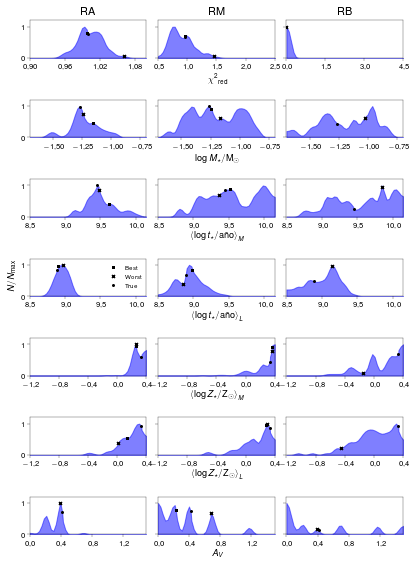

In [5]:
fig, axs = subplots(7, 3, sharey=True, figsize=(6,8))

ylim(0,1.2)

xlm = ((0.9,1.1),(0.5,2.5),(0,4.5)), ((-1.7,-0.7),)*3, ((8.5,10.15),)*3, ((8.5,10.15),)*3, ((-1.2,0.4),)*3, ((-1.2,0.4),)*3, ((0,1.5),)*3
kw = "chi_sq", "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
lb = spec_lb, jpas_lb, sdss_lb
tb = sfg_spec, sfg_jpas, sfg_sdss
tt = sfg_true
df = k_spec, k_jpas, k_sdss
ws = sfg_spec[worst_sfg_spec], sfg_jpas[worst_sfg_jpas], sfg_sdss[worst_sfg_sdss]
bs = sfg_spec[best_sfg_spec], sfg_jpas[best_sfg_jpas], sfg_sdss[best_sfg_sdss]

axs[3,0].set_ylabel(r"$N/N_\text{max}$")
for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    x = kw[i]
    t = tb[j]
    k = mean(df[j])
    true = tt[x+"_lib"] if i!=0 else max((k-2,0))/k
    worst = ws[j][x+"_mod" if i!=0 else x]
    best = bs[j][x+"_mod" if i!=0 else x]
    
    axs[i,j].set_xlim(xlm[i][j])
    n, xe = histogram(t[x+"_mod" if i!=0 else x], 25, range=xlm[i][j])
    xe = (xe[1:]+xe[:-1])*0.5
    xh = unique(sorted(list(linspace(xlm[i][j][0], xlm[i][j][1], 50))+[true, worst, best]))
    yh = interp(xh, xe, n)
    yh = gaussian_filter(yh, sigma=1)
    yh /= yh.max()
    
    axs[i,j].fill_between(xh, yh, edgecolor=colors[1], facecolor=colors[1], alpha=0.5)
    axs[i,j].plot(xh[where(xh==best)[0]], yh[where(xh==best)[0]], "s", ms=3, mfc="k", label=r"Best")
    axs[i,j].plot(xh[where(xh==worst)[0]], yh[where(xh==worst)[0]], "x", mew=1.5, ms=3, mec="k", label=r"Worst")
    axs[i,j].plot(xh[where(xh==true)[0]], yh[where(xh==true)[0]], "o", ms=3, mfc="k", label=r"True")

    if i==0: axs[i,j].set_title(lb[j])
    if i==3 and j==0: axs[i,j].legend(loc=1)
    if j==1: axs[i,j].set_xlabel((params[x] if i!=0 else r"${\chi^2}_\text{red}$"))
    axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4))

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
#fig.savefig("{}/sfg_chi_vs_pars".format("./img"))

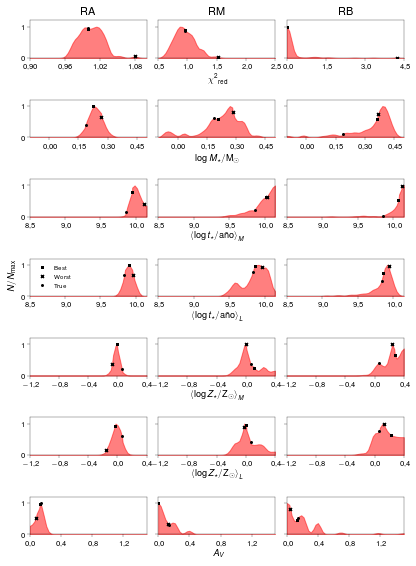

In [6]:
fig, axs = subplots(7, 3, sharey=True, figsize=(6,8))

ylim(0,1.2)

xlm = ((0.9,1.1),(0.5,2.5),(0,4.5)), ((-0.1, 0.5),)*3, ((8.5,10.15),)*3, ((8.5,10.15),)*3, ((-1.2,0.4),)*3, ((-1.2,0.4),)*3, ((0,1.5),)*3
kw = "chi_sq", "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
lb = spec_lb, jpas_lb, sdss_lb
tb = pag_spec, pag_jpas, pag_sdss
tt = pag_true
df = k_spec, k_jpas, k_sdss
ws = pag_spec[worst_pag_spec], pag_jpas[worst_pag_jpas], pag_sdss[worst_pag_sdss]
bs = pag_spec[best_pag_spec], pag_jpas[best_pag_jpas], pag_sdss[best_pag_sdss]

axs[3,0].set_ylabel(r"$N/N_\text{max}$")
for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    x = kw[i]
    t = tb[j]
    k = mean(df[j])
    true = tt[x+"_lib"] if i!=0 else max((k-2,0))/k
    worst = ws[j][x+"_mod" if i!=0 else x]
    best = bs[j][x+"_mod" if i!=0 else x]
    
    axs[i,j].set_xlim(xlm[i][j])
    n, xe = histogram(t[x+"_mod" if i!=0 else x], 25, range=xlm[i][j])
    xe = (xe[1:]+xe[:-1])*0.5
    xh = unique(sorted(list(linspace(xlm[i][j][0], xlm[i][j][1], 50))+[true, worst, best]))
    yh = interp(xh, xe, n)
    yh = gaussian_filter(yh, sigma=1)
    yh /= yh.max()
    
    axs[i,j].fill_between(xh, yh, edgecolor=colors[0], facecolor=colors[0], alpha=0.5)
    axs[i,j].plot(xh[where(xh==best)[0]], yh[where(xh==best)[0]], "s", ms=3, mfc="k", label=r"Best")
    axs[i,j].plot(xh[where(xh==worst)[0]], yh[where(xh==worst)[0]], "x", mew=1.5, ms=3, mec="k", label=r"Worst")
    axs[i,j].plot(xh[where(xh==true)[0]], yh[where(xh==true)[0]], "o", ms=3, mfc="k", label=r"True")

    if i==0: axs[i,j].set_title(lb[j])
    if i==3 and j==0: axs[i,j].legend(loc=2)
    if j==1: axs[i,j].set_xlabel((params[x] if i!=0 else r"${\chi^2}_\text{red}$"))
    axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=4))

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
#fig.savefig("{}/pag_chi_vs_pars".format("./img"))

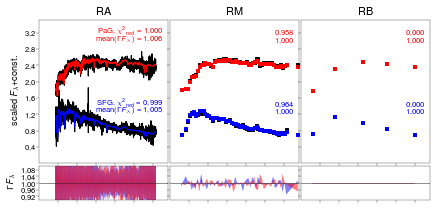

In [7]:
xlm, flm, rlm = (3000,9800), (0,3.5), (0.9,1.1)
wln = 6185.0

chis = (
    (sfg_spec["chi_sq"][best_sfg_spec], pag_spec["chi_sq"][best_pag_spec]),
    (sfg_jpas["chi_sq"][best_sfg_jpas], pag_jpas["chi_sq"][best_pag_jpas]),
    (sfg_sdss["chi_sq"][best_sfg_sdss], pag_sdss["chi_sq"][best_pag_sdss]),
)
names = (
    ("../inputs/proof_chi-useless/outs/spec/"+sfg_spec["input_file"][best_sfg_spec], "../inputs/proof_chi-useless/outs/spec/"+pag_spec["input_file"][best_pag_spec]),
    ("../inputs/proof_chi-useless/outs/jpas/"+sfg_jpas["input_file"][best_sfg_jpas], "../inputs/proof_chi-useless/outs/jpas/"+pag_jpas["input_file"][best_pag_jpas]),
    ("../inputs/proof_chi-useless/outs/sdss/"+sfg_sdss["input_file"][best_sfg_sdss], "../inputs/proof_chi-useless/outs/sdss/"+pag_sdss["input_file"][best_pag_sdss])
)
sy = "-", "s", "s"

fig = figure(figsize=(7,3.3))

ax11 = subplot2grid((10,30), (0,0), rowspan=8, colspan=10, title=spec_lb, ylabel=r"scaled $F_\lambda+$const.", xticklabels=[], xlim=xlm, ylim=flm)
ax21 = subplot2grid((10,30), (8,0), rowspan=2, colspan=10, ylabel=r"$\Gamma F_\lambda$", xticklabels=[], xlim=xlm, ylim=rlm)
ax12 = subplot2grid((10,30), (0,10), rowspan=8, colspan=10, title=jpas_lb, xticklabels=[], yticklabels=[], xlim=xlm, ylim=flm)
ax22 = subplot2grid((10,30), (8,10), rowspan=2, colspan=10, xticklabels=[], yticklabels=[], xlim=xlm, ylim=rlm)
ax13 = subplot2grid((10,30), (0,20), rowspan=8, colspan=10, title=sdss_lb, xticklabels=[], yticklabels=[], xlim=xlm, ylim=flm)
ax23 = subplot2grid((10,30), (8,20), rowspan=2, colspan=10, xticklabels=[], yticklabels=[], xlim=xlm, ylim=rlm)

axs = array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    
    name_s, name_p = names[j]
    chis_s, chis_p = chis[j]
    
    wls, fls_o, fls_m = loadtxt(name_s, usecols=(0,1,5), unpack=True)
    wlp, flp_o, flp_m = loadtxt(name_p, usecols=(0,1,5), unpack=True)
    
    if i==0:
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=9, prune="both"))
        axs[i,j].plot(wls, fls_o/fls_o[argmin(abs(wln-wls))], sy[j], color="k", mew=1, ms=3, mec="k")
        axs[i,j].plot(wls, fls_m/fls_m[argmin(abs(wln-wls))], sy[j], color=colors[1], mew=1, ms=3, mec=colors[1])

        axs[i,j].plot(wlp, flp_o/flp_o[argmin(abs(wln-wlp))]+1.5, sy[j], color="k", mew=1, ms=3, mec="k")
        axs[i,j].plot(wlp, flp_m/flp_m[argmin(abs(wln-wlp))]+1.5, sy[j], color=colors[0], mew=1, ms=3, mec=colors[0])
        
        if j==0:
            axs[i,j].text(0.95, 0.40, r"SFG, ${\chi^2}_\text{red}=%.3f$"%chis_s,color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.35, r"mean($\Gamma F_\lambda)=%.3f$"%mean(fls_m/fls_o), color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            
            axs[i,j].text(0.95, 0.90, r"PaG, ${\chi^2}_\text{red}=%.3f$"%chis_p,color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.85, r"mean($\Gamma F_\lambda)=%.3f$"%mean(flp_m/flp_o), color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
        else:
            axs[i,j].text(0.95, 0.40, r"$%.3f$"%chis_s,color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.35, r"$%.3f$"%mean(fls_m/fls_o), color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            
            axs[i,j].text(0.95, 0.90, r"$%.3f$"%chis_p,color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.85, r"$%.3f$"%mean(flp_m/flp_o), color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
    else:
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=6, prune="both"))
        axs[i,j].axhline(1.0, ls="-", lw=0.5, color=samples["dark"])
        
        axs[i,j].fill_between(wls, fls_m/fls_o, 1.0, lw=0.2, edgecolor=colors[1], facecolor=colors[1], alpha=0.5)
        axs[i,j].fill_between(wlp, flp_m/flp_o, 1.0, lw=0.2, edgecolor=colors[0], facecolor=colors[0], alpha=0.5)
        
#fig.savefig("{}/best_fitting".format("./img"))

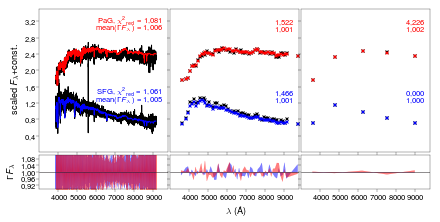

In [8]:
xlm, flm, rlm = (3000,9800), (0,3.5), (0.9,1.1)
wln = 6185.0

chis = (
    (sfg_spec["chi_sq"][worst_sfg_spec], pag_spec["chi_sq"][worst_pag_spec]),
    (sfg_jpas["chi_sq"][worst_sfg_jpas], pag_jpas["chi_sq"][worst_pag_jpas]),
    (sfg_sdss["chi_sq"][worst_sfg_sdss], pag_sdss["chi_sq"][worst_pag_sdss]),
)
names = (
    ("../inputs/proof_chi-useless/outs/spec/"+sfg_spec["input_file"][worst_sfg_spec], "../inputs/proof_chi-useless/outs/spec/"+pag_spec["input_file"][worst_pag_spec]),
    ("../inputs/proof_chi-useless/outs/jpas/"+sfg_jpas["input_file"][worst_sfg_jpas], "../inputs/proof_chi-useless/outs/jpas/"+pag_jpas["input_file"][worst_pag_jpas]),
    ("../inputs/proof_chi-useless/outs/sdss/"+sfg_sdss["input_file"][worst_sfg_sdss], "../inputs/proof_chi-useless/outs/sdss/"+pag_sdss["input_file"][worst_pag_sdss])
)
sy = "-", "x", "x"

fig = figure(figsize=(7,3.3))

ax11 = subplot2grid((10,30), (0,0), rowspan=8, colspan=10, ylabel=r"scaled $F_\lambda+$const.", xticklabels=[], xlim=xlm, ylim=flm)
ax21 = subplot2grid((10,30), (8,0), rowspan=2, colspan=10, ylabel=r"$\Gamma F_\lambda$", xlim=xlm, ylim=rlm)
ax12 = subplot2grid((10,30), (0,10), rowspan=8, colspan=10, xticklabels=[], yticklabels=[], xlim=xlm, ylim=flm)
ax22 = subplot2grid((10,30), (8,10), rowspan=2, colspan=10, xlabel=r"$\lambda$ (\AA)", yticklabels=[], xlim=xlm, ylim=rlm)
ax13 = subplot2grid((10,30), (0,20), rowspan=8, colspan=10, xticklabels=[], yticklabels=[], xlim=xlm, ylim=flm)
ax23 = subplot2grid((10,30), (8,20), rowspan=2, colspan=10, yticklabels=[], xlim=xlm, ylim=rlm)

axs = array([[ax11,ax12,ax13],[ax21,ax22,ax23]])

for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    axs[i,j].xaxis.set_major_locator(MaxNLocator(nbins=7, prune="both"))
    
    name_s, name_p = names[j]
    chis_s, chis_p = chis[j]
    
    wls, fls_o, fls_m = loadtxt(name_s, usecols=(0,1,5), unpack=True)
    wlp, flp_o, flp_m = loadtxt(name_p, usecols=(0,1,5), unpack=True)
    
    if i==0:
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=9, prune="both"))
        axs[i,j].plot(wls, fls_o/fls_o[argmin(abs(wln-wls))], sy[j], color="k", mew=1, ms=3, mec="k")
        axs[i,j].plot(wls, fls_m/fls_m[argmin(abs(wln-wls))], sy[j], color=colors[1], mew=1, ms=3, mec=colors[1])

        axs[i,j].plot(wlp, flp_o/flp_o[argmin(abs(wln-wlp))]+1.5, sy[j], color="k", mew=1, ms=3, mec="k")
        axs[i,j].plot(wlp, flp_m/flp_m[argmin(abs(wln-wlp))]+1.5, sy[j], color=colors[0], mew=1, ms=3, mec=colors[0])
        
        if j==0:
            axs[i,j].text(0.95, 0.40, r"SFG, ${\chi^2}_\text{red}=%.3f$"%chis_s,color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.35, r"mean($\Gamma F_\lambda)=%.3f$"%mean(fls_m/fls_o), color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            
            axs[i,j].text(0.95, 0.90, r"PaG, ${\chi^2}_\text{red}=%.3f$"%chis_p,color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.85, r"mean($\Gamma F_\lambda)=%.3f$"%mean(flp_m/flp_o), color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
        else:
            axs[i,j].text(0.95, 0.40, r"$%.3f$"%chis_s,color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.35, r"$%.3f$"%mean(fls_m/fls_o), color=colors[1], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            
            axs[i,j].text(0.95, 0.90, r"$%.3f$"%chis_p,color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
            axs[i,j].text(0.95, 0.85, r"$%.3f$"%mean(flp_m/flp_o), color=colors[0], fontsize=tsize, ha="right", transform=axs[i,j].transAxes)
    else:
        axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=6, prune="both"))
        axs[i,j].axhline(1.0, ls="-", lw=0.5, color=samples["dark"])
        
        axs[i,j].fill_between(wls, fls_m/fls_o, 1.0, lw=0.2, edgecolor=colors[1], facecolor=colors[1], alpha=0.5)
        axs[i,j].fill_between(wlp, flp_m/flp_o, 1.0, lw=0.2, edgecolor=colors[0], facecolor=colors[0], alpha=0.5)
        
#fig.savefig("{}/worst_fitting".format("./img"))

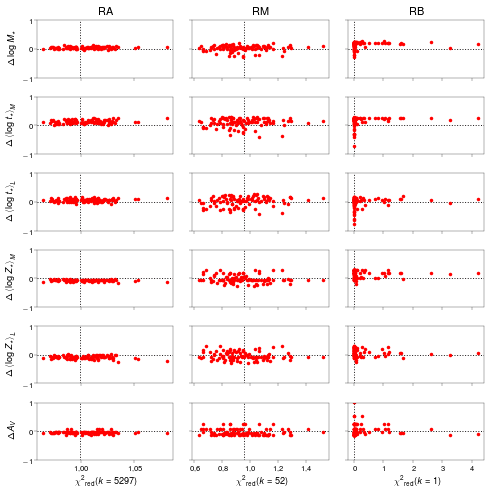

In [9]:
fig, axs = subplots(6, 3, sharex="col", sharey=True, figsize=(7,7))

ylim(-1,1)

kw = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
lb = spec_lb, jpas_lb, sdss_lb
tb = pag_spec, pag_jpas, pag_sdss
df = k_spec, k_jpas, k_sdss

for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    x = kw[i]
    t = tb[j]
    k = mean(df[j])

    axs[i,j].axhline(ls=":", color=samples["dark"])
    axs[i,j].axvline(max((k-2,0))/k, ls=":", color=samples["dark"])
    axs[i,j].plot(t["chi_sq"], t[x+"_mod"]-pag_true[x+"_lib"], ".r", mew=0)
    
    if axs[i,j].is_first_row(): axs[i,j].set_title(lb[j])
    if axs[i,j].is_last_row(): axs[i,j].set_xlabel(r"${\chi^2}_\text{red}(k=%d)$"%k)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(Delta[x])

fig.tight_layout()
#fig.savefig("{}/residual_vs_chi".format("./img"))

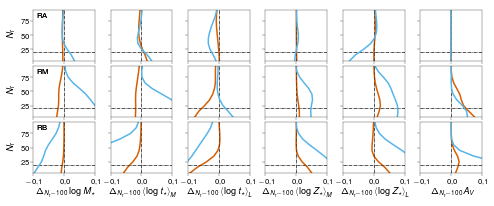

In [10]:
kw = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
lbs = spec_lb, jpas_lb, sdss_lb
tbs = (pag_spec, pag_jpas, pag_sdss), (sfg_spec, sfg_jpas, sfg_sdss)
tru = pag_true, sfg_true
col = samples["hot"], samples["cold"]

fig, axs = subplots(len(tbs[0]), len(kw), figsize=(7,3), sharex=True, sharey=True)

#axs[0,0].set_xticks([-0.05,0.0,+0.05])

Ns = arange(5, NR, 10, dtype=int)
group = range(NR)
N_comb = 1

ylim(Ns[0],Ns[-1])
xlim(-0.1,+0.1)

for m in xrange(2):
    cl = col[m]
    tb = tbs[m]
    bias_ave = zeros(axs.shape+(Ns.size,))
    for l,N in enumerate(Ns):
        matrix = zeros(axs.shape+(N_comb,))
        for k,comb in enumerate(it.combinations(group,N)):
            for i,j in it.product(xrange(axs.shape[0]),xrange(axs.shape[1])):
                matrix[i,j,k] = median(tb[i][kw[j]+"_mod"][array(comb)] - tru[m][kw[j]+"_lib"])
            if k==N_comb-1: break
        bias_ave[:,:,l] = mean(matrix, axis=2)

    for i,j in it.product(xrange(axs.shape[0]),xrange(axs.shape[1])):
        res_max = median(tb[i][kw[j]+"_mod"]-tru[m][kw[j]+"_lib"])
        axs[i,j].axvline(ls="-.", lw=0.5, color=samples["dark"])
        axs[i,j].axhline(20, ls="-.", lw=0.5, color=samples["dark"])
        axs[i,j].plot(gaussian_filter(bias_ave[i,j,:]-res_max,1.5), Ns, "-", lw=1.5, color=cl)
        
        if axs[i,j].is_first_col():
            axs[i,j].set_ylabel(r"$N_\text{r}$")
            axs[i,j].text(0.05, 0.85, lbs[i], fontsize=tsize, ha="left", transform=axs[i,j].transAxes)
        if axs[i,j].is_last_row(): axs[i,j].set_xlabel(Delta[kw[j]].replace(r"\Delta", r"\Delta_{{N_\text{r}}-100}"))

fig.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig("{}/n_realisations".format(od))